# Stacking Model

In the previous notebooks, I have built different models. In this notebook, I will use the three best ones in the Stacking Model in order to try and improve F1 and Accuracy and combat overfitting.

---

In [2]:
# Imports
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

# Import my custom functions for fitting and scoring models, tokenizing, and plotting residuals.
import functions_for_modeling

In [3]:
# Read the data
reddit = pd.read_csv('../data/reddit_cleaned_removed_words.csv')

In [4]:
# Split the data
X = reddit['all_text']
y = reddit['subreddit_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 18,  stratify = y)

---

## Stacking

In [5]:
# Fit using hyperparameters from the best models found in previous notebooks.

level1_estimators = [
    ('nb', MultinomialNB(alpha=0.8)),
    ('xgb', XGBClassifier(subsample=0.9, reg_alpha=0.4, max_depth=5, learning_rate=0.14, gamma=0.28, colsample_bytree=0.73)),
    ('gb', GradientBoostingClassifier(n_estimators=200, max_depth=3, learning_rate= 0.12)),
    
]

pipe_staking = Pipeline([
    ('cvec', CountVectorizer(stop_words = 'english')),
    ('staking', StackingClassifier(estimators=level1_estimators,
                                 final_estimator=LogisticRegression()))
])

pipe_params = {
    'cvec__max_features': [3000, 4000, 5000],
    'cvec__min_df': [2, 3, 4, 5],
    'cvec__max_df': [0.8, 0.9, 0.95],
    'staking__final_estimator__C': np.linspace(0.01, 1, 15),
}

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=18)

st = RandomizedSearchCV(pipe_staking, 
                       param_distributions = pipe_params,
                       n_jobs = -1,
                       cv = kfold, 
                       random_state=18,
                       n_iter=40)

In [12]:
st = functions_for_modeling.model_fit_scores(st, X_train, y_train, X_test, y_test)

Cross Validation Score: 0.8911894814450726
Best Parameters: {'staking__final_estimator__C': 1.0, 'cvec__min_df': 2, 'cvec__max_features': 5000, 'cvec__max_df': 0.8}
Train accuracy: 0.9622279129321383
Test accuracy: 0.9040307101727447
F1 score: 0.8466257668711656


This model performs better than my previous best model - Naive Bayes. I will try to improve it even more with my best-performing custom Tokenizer - NLTP Word Tokenizer with Stemming

---

## Stacking with Tokenizer

In [6]:
tb_stem_st = functions_for_modeling.model_tokenazer(StackingClassifier(estimators=level1_estimators, final_estimator=LogisticRegression(C=1)), 'sc', functions_for_modeling.textblob_tokenizer, 2, 4000, 0.8, X_train, y_train, X_test, y_test)

Cross Validation Score: 0.8918407471123126
Train accuracy: 0.9615877080665813
Test accuracy: 0.9097888675623801
F1 score: 0.8507936507936509


In [6]:
t_stem_st = functions_for_modeling.model_tokenazer(StackingClassifier(estimators=level1_estimators, final_estimator=LogisticRegression(C=1)), 'sc', functions_for_modeling.tokenizer_stemmer, 2, 4000, 0.8, X_train, y_train, X_test, y_test)

Cross Validation Score: 0.8950376832964692
Train accuracy: 0.9647887323943662
Test accuracy: 0.9021113243761996
F1 score: 0.838095238095238


The model with Blob Tokenizer and Stemming (tb_stem_st) improved the scores and reduced overfitting. I will use a Random Search to find better hyperparameters for this model. 

In [7]:
# Random search parameters of the best tokenized model to improve scores.
pipe_tn = Pipeline([
    ('cvec', CountVectorizer(tokenizer=functions_for_modeling.textblob_tokenizer)),
    ('staking', StackingClassifier(estimators=level1_estimators,
                                 final_estimator=LogisticRegression()))
])

pipe_params_tn = {
    'cvec__max_features': [3000, 4000, 5000],
    'cvec__min_df': [2, 3, 4],
    'cvec__max_df': [0.9, 0.8],
    'staking__final_estimator__C': [0.8, 0.9, 1]
}

st_tn = RandomizedSearchCV(pipe_tn, 
                       param_distributions = pipe_params_tn,
                       n_jobs = -1,
                       cv = 5, 
                       random_state=18,
                       n_iter=20)


st_tn = functions_for_modeling.model_fit_scores(st_tn, X_train, y_train, X_test, y_test)

Cross Validation Score: 0.8937597280249037
Best Parameters: {'staking__final_estimator__C': 0.8, 'cvec__min_df': 2, 'cvec__max_features': 5000, 'cvec__max_df': 0.8}
Train accuracy: 0.9647887323943662
Test accuracy: 0.9040307101727447
F1 score: 0.840764331210191


The Random search improved the scores, but they are just a bit lower than the Stacking model without Tokenizer.

---

## Plot the Residuals of the best model in this notebook 

My best model for this notebook and this project is Staking without Tokenizer.

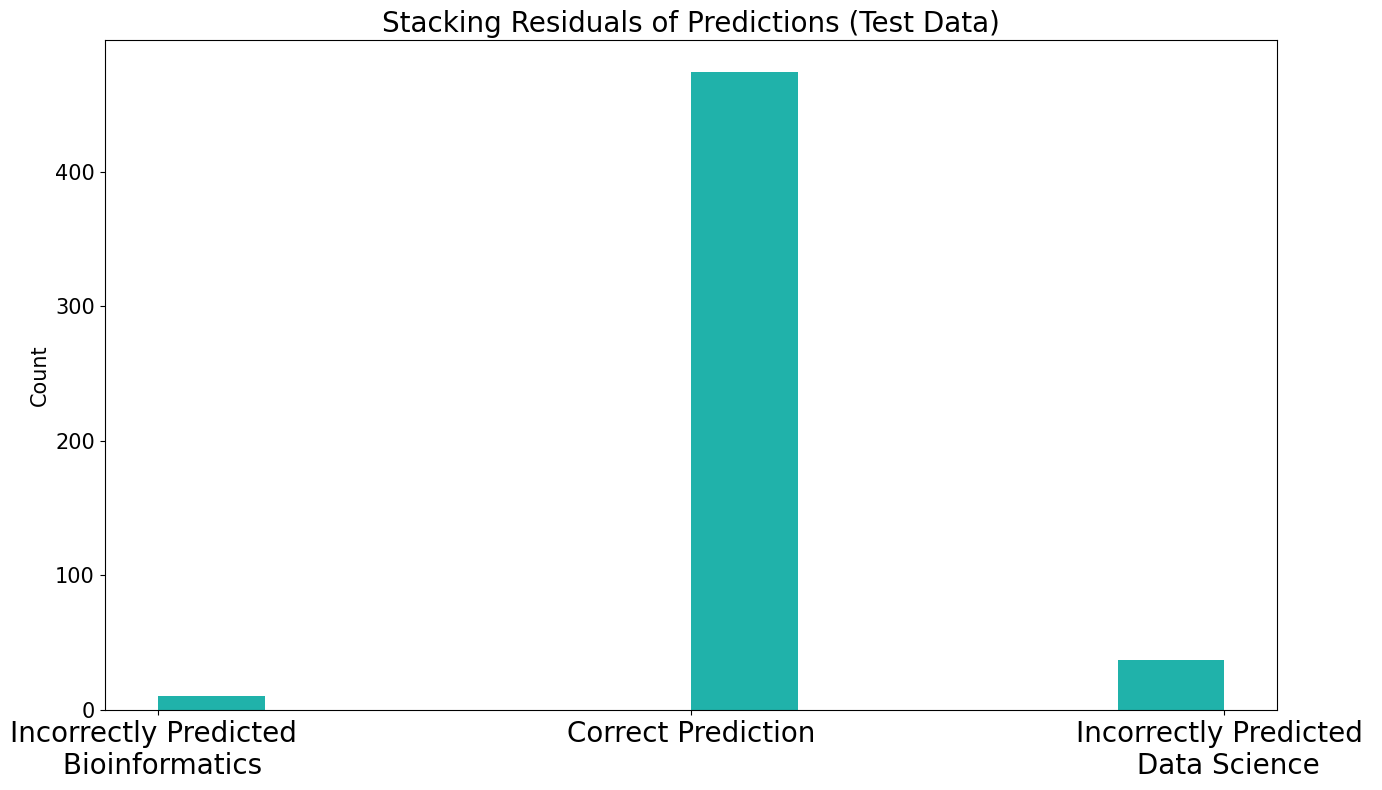

In [7]:
# Plot the resuduals of the mest model for this notebook
functions_for_modeling.plot_residuals(tb_stem_st, X_test, y_test, 'Stacking', 'st_residuals')

My best model still has an imbalanced error, but the amount of incorrectly predicted Data Science texts is less than in my previous best model - Naive Bayes.

#####Stacking improved F1 score by 0.04, Test Accuracy by 2%, and Cross-Validation score by 1%. It reduced overfitting by 0.02.

---

# Conclusions

My best model for this project is Stacking with Naive Bayes, Gradient Boosting, and XGBoost with Count vectorization and Text Blob Tokenizing and Stemming. It has a high F1 score of ####0.846 and a test accuracy of ####90%. 
I would recommend training my best model with a broader specter of data from different websites and using more Bioinformatics data to battle imbalanced errors in predictions for further development of the model to differentiate Bioinformatics texts from Data Science texts.